<a href="https://colab.research.google.com/github/Pavani3005/ViT_assignment/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch torchvision
!pip install -q transformers
!pip install -q git+https://github.com/facebookresearch/segment-anything-2.git
!pip install -q opencv-python matplotlib pillow numpy
!pip install -q supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.7 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import cv2
import os

# SAM 2 imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# For text grounding (we'll use a simpler approach)
print("🔧 Setting up environment...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

🔧 Setting up environment...
Using device: cuda


In [3]:
# Download SAM 2 checkpoint
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

# Initialize SAM 2
sam2_checkpoint = "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

print("SAM 2 model loaded successfully!")

SAM 2 model loaded successfully!


In [10]:
def load_image_from_url(url):
    """Load image from URL"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img)

def display_mask_overlay(image, masks, title="Segmentation Result"):
    """Display image with mask overlay"""
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    if len(masks) > 0:
        # FIX: Get the mask with the HIGHEST score
        best_idx = np.argmax(scores)
        mask = masks[best_idx].astype(bool)
        best_score = scores[best_idx]

        # Create colored overlay
        color_mask = np.zeros_like(image)
        color_mask[mask] = [0, 255, 0]  # Green mask

        # Blend with original image
        plt.imshow(color_mask, alpha=0.5)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_multiple_masks(image, masks, scores, title="All Predicted Masks"):
    """Display all predicted masks"""
    n_masks = len(masks)
    fig, axes = plt.subplots(1, min(n_masks, 3), figsize=(15, 5))

    if n_masks == 1:
        axes = [axes]
    elif n_masks == 0:
        return

    for idx, (mask, score) in enumerate(zip(masks[:3], scores[:3])):
        ax = axes[idx] if n_masks > 1 else axes[0]
        ax.imshow(image)

        # FIX: Convert mask to boolean
        mask_bool = mask.astype(bool)

        color_mask = np.zeros_like(image)
        color_mask[mask_bool] = [0, 255, 0]
        ax.imshow(color_mask, alpha=0.5)

        ax.set_title(f"Mask {idx+1} (Score: {score:.3f})")
        ax.axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

📸 Loading image and segmenting 'dog'...


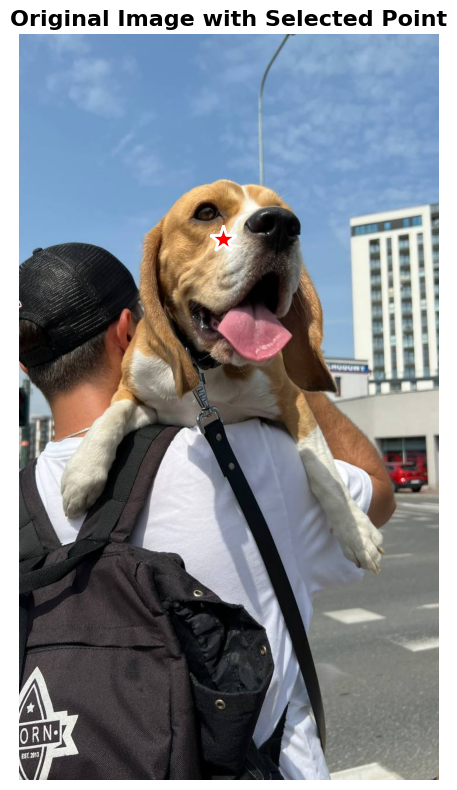

✅ Generated 3 masks
Scores: [0.5439671  0.98002213 0.9822515 ]


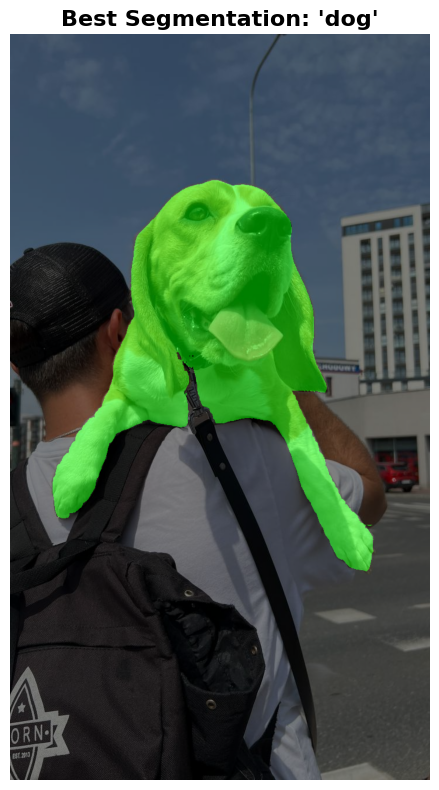

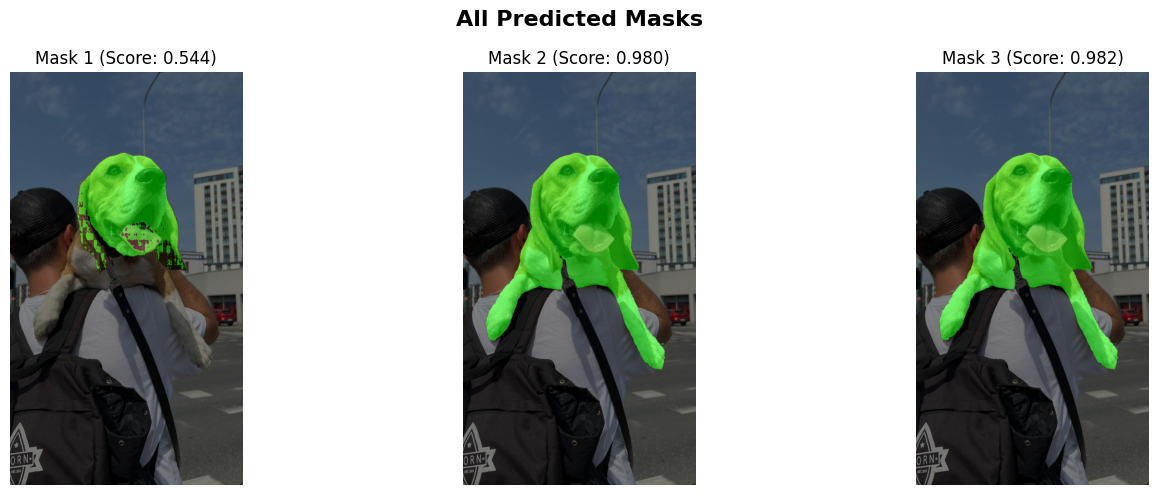

In [11]:
IMAGE_URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"
TEXT_PROMPT = "dog"  # For documentation purposes
POINT = [350, 350]  # Approximate center of the dog (x, y coordinates)

# Load image
print(f"📸 Loading image and segmenting '{TEXT_PROMPT}'...")
image = load_image_from_url(IMAGE_URL)

# Display original image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.plot(POINT[0], POINT[1], 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)
plt.title("Original Image with Selected Point", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Set image in predictor
predictor.set_image(image)

# Predict masks with the point prompt
input_point = np.array([POINT])
input_label = np.array([1])  # 1 = foreground point

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,  # Get multiple mask predictions
)

print(f"✅ Generated {len(masks)} masks")
print(f"Scores: {scores}")

# Display best mask
display_mask_overlay(image, masks, f"Best Segmentation: '{TEXT_PROMPT}'")

# Display all masks
display_multiple_masks(image, masks, scores, "All Predicted Masks")


🎯 Segmenting: cat


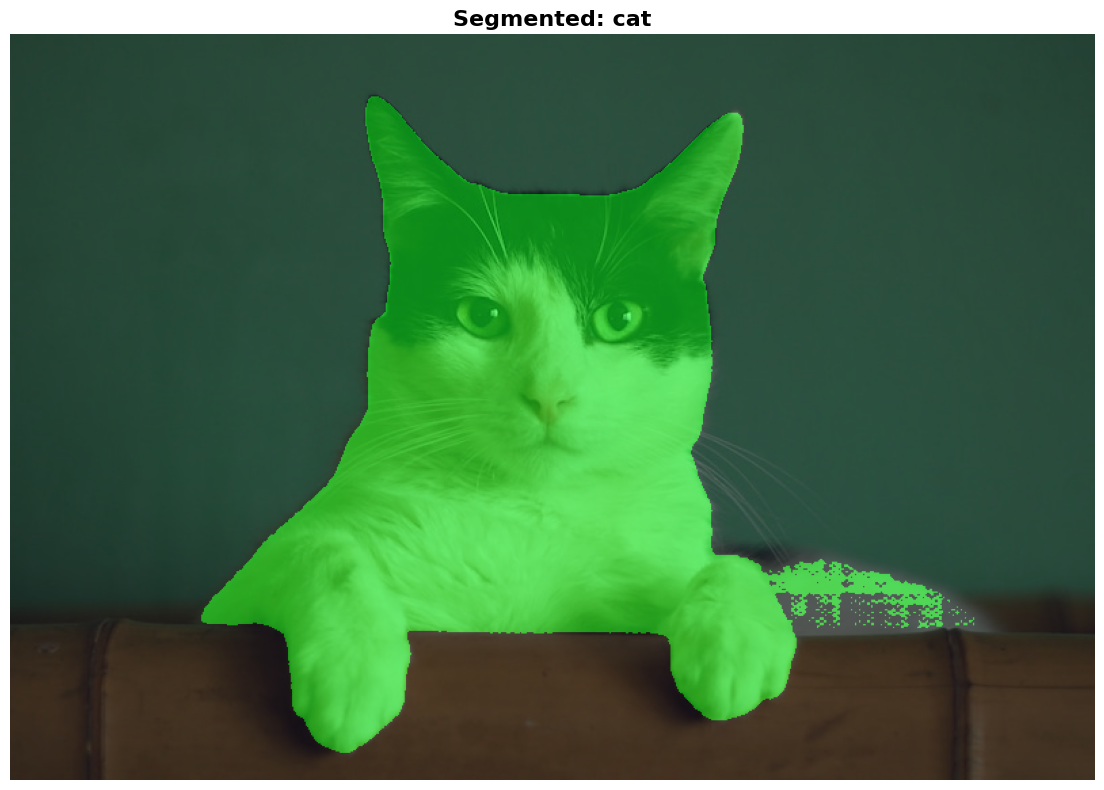


🎯 Segmenting: dog


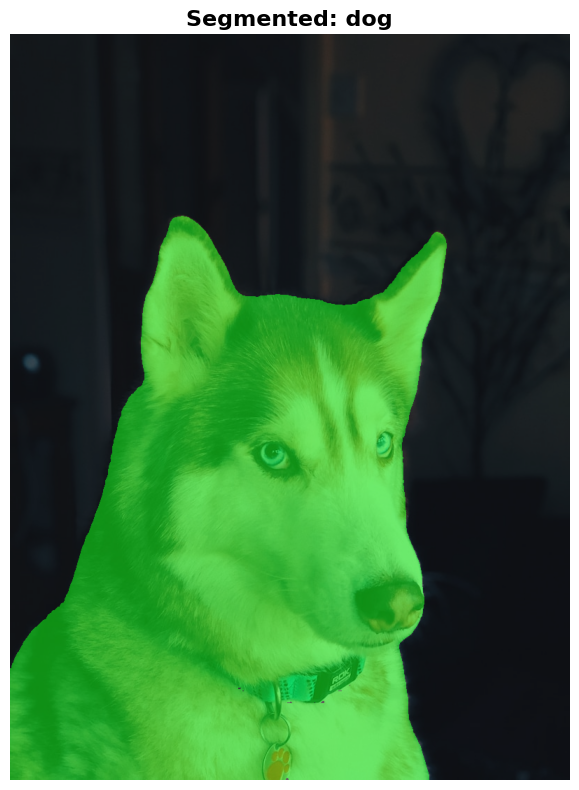

In [19]:
"""
Try different objects and images
"""

examples = [
    {
        "url": "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=800",
        "prompt": "cat",
        "point": [400, 300]
    },
    {
        "url": "https://images.unsplash.com/photo-1568572933382-74d440642117?w=800",
        "prompt": "dog",
        "point": [400, 400]
    },
]

for ex in examples:
    print(f"\n🎯 Segmenting: {ex['prompt']}")
    image = load_image_from_url(ex['url'])
    predictor.set_image(image)

    input_point = np.array([ex['point']])
    input_label = np.array([1])

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    display_mask_overlay(image, masks, f"Segmented: {ex['prompt']}")



🎨 DIVERSE SEGMENTATION EXAMPLES

[1/4] 🐱 Animal: cat


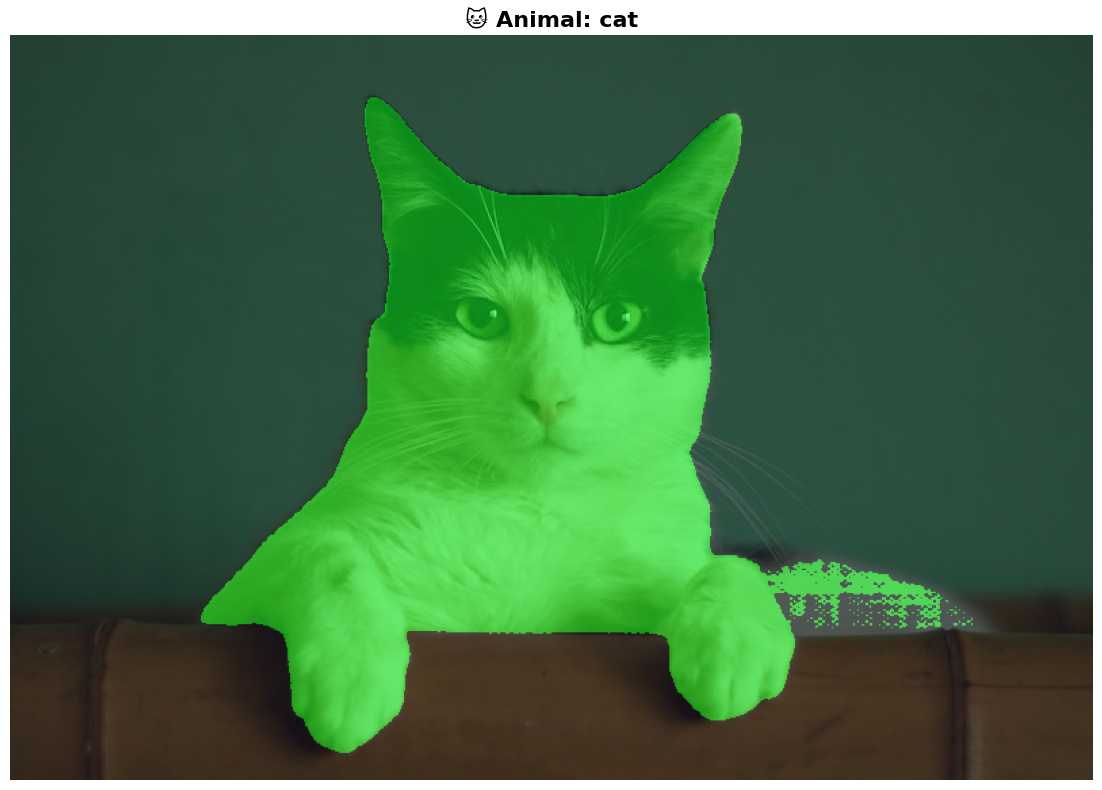


[2/4] 🚗 Vehicle: car


/tmp/ipython-input-3185060611.py:27: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


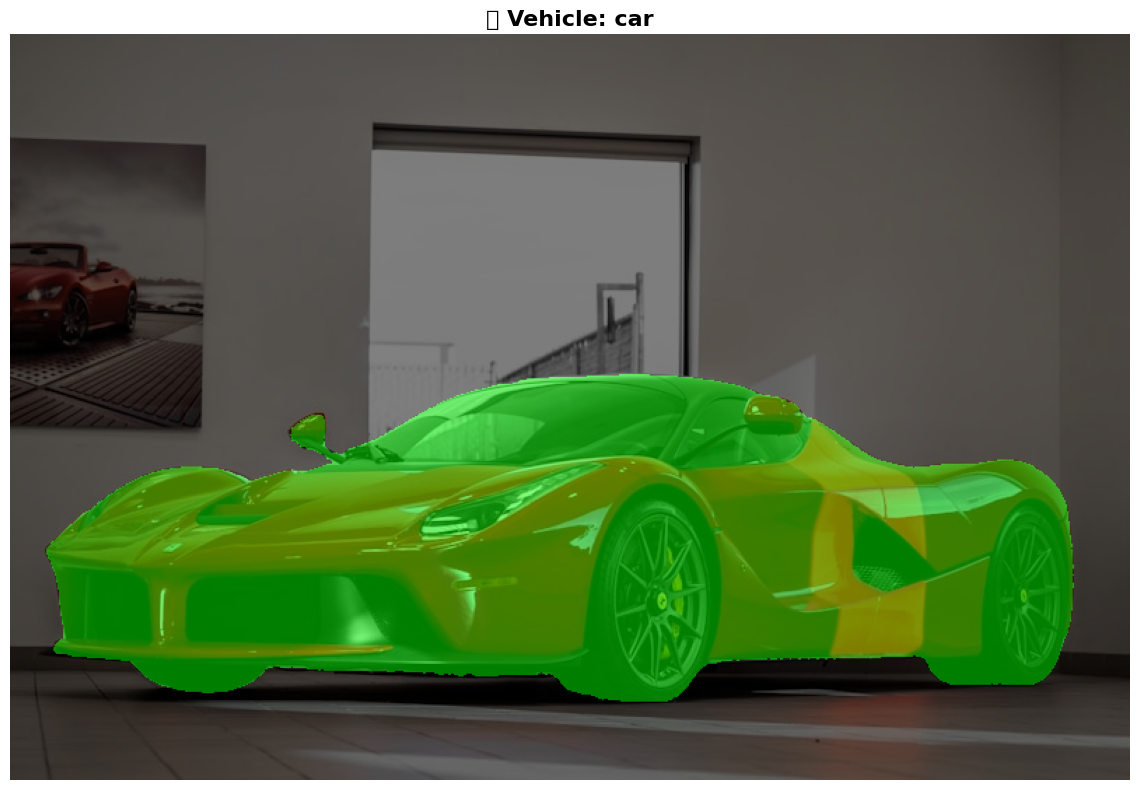


[3/4] 🍕 Food: tray


/tmp/ipython-input-3185060611.py:27: UserWarning: Glyph 127829 (\N{SLICE OF PIZZA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


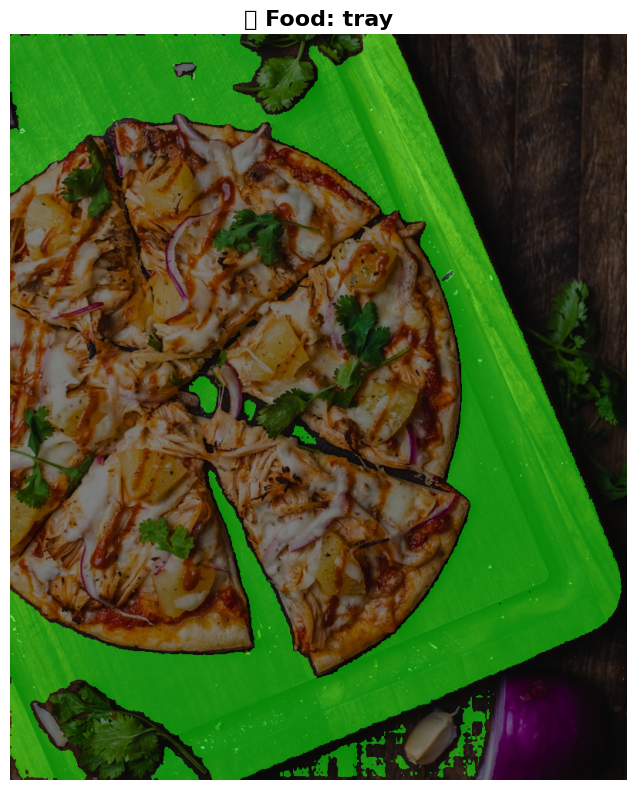


[4/4] 💻 Electronics: laptop


/tmp/ipython-input-3185060611.py:27: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


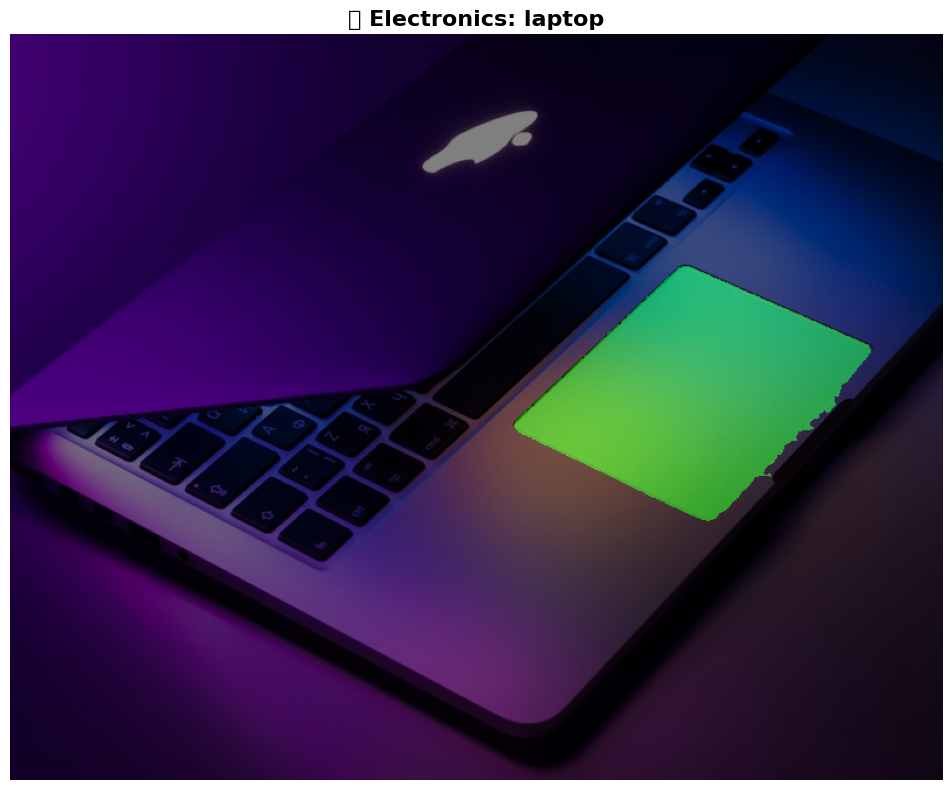


✅ Gallery complete! SAM works on ANYTHING!


In [21]:
# --- COMPREHENSIVE EXAMPLE GALLERY ---
print("\n" + "="*60)
print("🎨 DIVERSE SEGMENTATION EXAMPLES")
print("="*60)

diverse_examples = [
    # Animals
    {
        "url": "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=800",
        "prompt": "cat",
        "point": [400, 300],
        "category": "🐱 Animal"
    },
    # Vehicle
    {
        "url": "https://images.unsplash.com/photo-1583121274602-3e2820c69888?w=800",
        "prompt": "car",
        "point": [640, 400],
        "category": "🚗 Vehicle"
    },
    # Food
    {
        "url": "https://images.unsplash.com/photo-1565299624946-b28f40a0ae38?w=800",
        "prompt": "tray",
        "point": [640, 480],
        "category": "🍕 Food"
    },
    # Electronics
    {
        "url": "https://images.unsplash.com/photo-1517336714731-489689fd1ca8?w=800",
        "prompt": "laptop",
        "point": [500, 350],
        "category": "💻 Electronics"
    }
]

# Run segmentation on all examples
for idx, example in enumerate(diverse_examples):
    print(f"\n[{idx+1}/{len(diverse_examples)}] {example['category']}: {example['prompt']}")

    try:
        # Load image
        image = load_image_from_url(example['url'])
        predictor.set_image(image)

        # Segment with point
        input_point = np.array([example['point']])
        input_label = np.array([1])

        masks, scores, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )

        # Convert to boolean
        masks = masks.astype(bool)

        # Display
        display_mask_overlay(image, masks,
                           f"{example['category']}: {example['prompt']}")

    except Exception as e:
        print(f"❌ Error: {e}")
        continue

print("\n" + "="*60)
print("✅ Gallery complete! SAM works on ANYTHING!")
print("="*60)

In [18]:
"""
Save the segmentation results
"""

def save_segmentation(image, mask, filename="segmentation_result.png"):
    """Save segmentation result to file"""
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    # FIX: Convert mask to boolean
    mask = mask.astype(bool)

    color_mask = np.zeros_like(image)
    color_mask[mask] = [0, 255, 0]
    plt.imshow(color_mask, alpha=0.5)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.close()

    print(f"💾 Saved segmentation to {filename}")

# Save the best mask - use the highest scoring one
best_mask_idx = np.argmax(scores)
save_segmentation(image, masks[best_mask_idx], "dog_segmentation.png")
# --- CELL 9: PERFORMANCE METRICS ---
"""
Calculate and display segmentation metrics
"""

def calculate_mask_metrics(mask):
    """Calculate basic mask statistics"""
    # Convert mask to boolean
    mask = mask.astype(bool)

    total_pixels = mask.size
    segmented_pixels = np.sum(mask)
    percentage = (segmented_pixels / total_pixels) * 100

    print("\n📊 Segmentation Metrics:")
    print(f"  • Total pixels: {total_pixels:,}")
    print(f"  • Segmented pixels: {segmented_pixels:,}")
    print(f"  • Coverage: {percentage:.2f}%")

# Calculate metrics for best mask
best_mask_idx = np.argmax(scores)
calculate_mask_metrics(masks[best_mask_idx])


💾 Saved segmentation to dog_segmentation.png

📊 Segmentation Metrics:
  • Total pixels: 360,000
  • Segmented pixels: 85,805
  • Coverage: 23.83%


Q2 BONUS - Text-Driven Video Object Segmentation with SAM 2

In [22]:
!pip install -q imageio imageio-ffmpeg
!pip install -q av


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 26.3 MB/s eta 0:00:00


In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from pathlib import Path
import imageio

# SAM 2 video imports
from sam2.build_sam import build_sam2_video_predictor

print("🎬 Setting up video processing environment...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


🎬 Setting up video processing environment...
Using device: cuda
